In [14]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.models as models
import torchvision.models as vmodels
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import glob
import librosa
import librosa.display
import soundfile as sf
from scipy.interpolate import interp1d
import IPython.display as ipd
import ast
import time

In [18]:
# Hyper parameters
EPOCHS = 10
TRAIN_BATCH_SIZE = 4
N_MELS = 256
MAXLEN = 800

In [3]:
## need to work on padding tensors to have consistent shape

class MelSpecDataset(Dataset):
    def __init__(self, source_file):
        self.source = pd.read_csv(source_file)
        
        mel_specs = []
        wvs = []
        for idx in range(len(self.source)):
            ex = self.source.iloc[idx]
            waveform = ex.waveform

            if isinstance(waveform, str): 
                wv = ','.join(ex.waveform.replace('[ ', '[').split())
                wv = np.array(ast.literal_eval(wv))
                waveform = torch.from_numpy(wv).view(1, -1).to(dtype=torch.float32)

                wvs.append(waveform)

            sample_rate = int(ex.sample_rate)
            
            waveform = waveform.view(1, 1, -1)
            
            mel_spec = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=N_MELS)(waveform)
            mel_spec = self.__reshape(mel_spec[0])
                        
            #mfcc = librosa.feature.mfcc(y=wv, sr=ex.sample_rate)

            mel_specs.append(mel_spec)

        if 'mel_spec' in self.source:
            self.source = self.source.assign(mel_spec=mel_specs)
        else:
            self.source.insert(4, "mel_spec", mel_specs, True)
            
        # drop waveform data for now to save memory
        self.source = self.source.drop(columns=['waveform'])
        
        # uncomment to visualize waveform
        #if len(wvs) > 0:
        #    self.source = self.source.assign(waveform=wvs)
    def __reshape(self, mel_spec):
        diff = MAXLEN - mel_spec.shape[2]
        if diff > 0:
            # pad
            s = int(diff/2) 
            e = diff - s
            mel_spec = F.pad(input=mel_spec, pad=(s, e, 0, 0, 0, 0), mode='constant', value=0)
        else:
            # trim
            mel_spec = mel_spec.narrow(2, diff*-1, MAXLEN)

        mel_spec = mel_spec.repeat(3, 1, 1)
        return mel_spec
    def get_waveform(self, idx):
        ex = self.source.iloc[idx]
        return (ex.waveform, ex.sample_rate)
    def __getitem__(self, idx):
        ex = self.source.iloc[idx]
        return (ex.mel_spec, int(ex.species_id))
    def __len__(self):
        return len(self.source)

In [9]:
class RainforestNet(nn.Module):
    def __init__(self):
        super(RainforestNet, self).__init__()
        self.resnet = vmodels.resnet50(pretrained=True)
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 225)
        self.fc3 = nn.Linear(225, 24)

    def forward(self, x):
        x = self.resnet(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.fc2(x)
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
trainset = MelSpecDataset('train_classified-all.csv')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE,shuffle=True)

In [10]:
# CUDA
is_cuda = True and torch.cuda.is_available()
device = torch.device('cuda') if is_cuda else torch.device('cpu')

print ('cuda: ', is_cuda)

torch.cuda.empty_cache()

cuda:  True


In [11]:
#resnet = vmodels.resnet50(pretrained=True).to(device)
model = RainforestNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
print (len(trainset))

1216


In [20]:
# when tensors are of the same shape from the dataset, will use trainloader instead of trainset directly

start_time = time.time()

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #print (inputs.shape)
        #print (labels)
                        
        optimizer.zero_grad()
                
        output = model(inputs)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d %5d] loss: %.3f' %
                    (epoch+1, i+1, running_loss / 50))
            running_loss = 0.0
            
end_time = time.time()
print ('\n-------- DONE --------')
print ('start time: {}'.format(start_time))
print ('end time: {}\n'.format(end_time))

duration = end_time-start_time
print ('training duration: {}'.format(duration))

torch.save(model.state_dict(), 'models/rainforest{}.pt'.format(end_time))

[1    50] loss: 3.135
[1   100] loss: 2.913
[1   150] loss: 2.777
[1   200] loss: 2.640
[1   250] loss: 2.338
[1   300] loss: 2.369
[2    50] loss: 2.129
[2   100] loss: 2.197
[2   150] loss: 2.029
[2   200] loss: 1.865
[2   250] loss: 1.821
[2   300] loss: 1.785
[3    50] loss: 1.678
[3   100] loss: 1.559
[3   150] loss: 1.488
[3   200] loss: 1.336
[3   250] loss: 1.224
[3   300] loss: 1.217
[4    50] loss: 1.253
[4   100] loss: 1.053
[4   150] loss: 0.956
[4   200] loss: 0.981
[4   250] loss: 0.919
[4   300] loss: 0.804
[5    50] loss: 0.754
[5   100] loss: 0.786
[5   150] loss: 0.828
[5   200] loss: 0.583
[5   250] loss: 0.611
[5   300] loss: 0.720
[6    50] loss: 0.500
[6   100] loss: 0.624
[6   150] loss: 0.569
[6   200] loss: 0.524
[6   250] loss: 0.523
[6   300] loss: 0.549
[7    50] loss: 0.488
[7   100] loss: 0.516
[7   150] loss: 0.439
[7   200] loss: 0.373
[7   250] loss: 0.464
[7   300] loss: 0.371
[8    50] loss: 0.384
[8   100] loss: 0.455
[8   150] loss: 0.269
[8   200] 

In [7]:
# visualize

# for idx in range(len(train_classified)):
#     ex = train_classified.iloc[idx]
#     mfcc = ex.mfcc
#     fig, ax = plt.subplots()
#     img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
#     fig.colorbar(img, ax=ax)
#     ax.set(title='MFCC')

In [44]:
import wave
import struct

def signal_to_wav(signal, fname, Fs):
    """Convert a numpy array into a wav file.

     Args
     ----
     signal : 1-D numpy array
         An array containing the audio signal.
     fname : str
         Name of the audio file where the signal will be saved.
     Fs: int
        Sampling rate of the signal.

    """
    data = struct.pack('>' + ('d'*len(signal)), *signal)
    wav_file = wave.open(fname, 'wb')
    wav_file.setnchannels(1)
    wav_file.setsampwidth(2)
    wav_file.setframerate(Fs)
    wav_file.writeframes(data)
    wav_file.close()

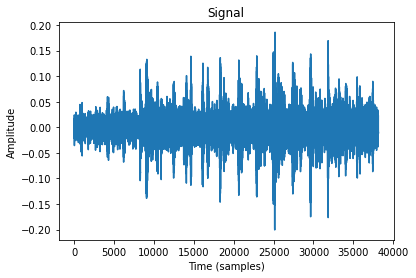

In [51]:
# this will currently not work since the waveforms are being dropped in the dataframe
# 

import matplotlib.pyplot as plt
wv, sample_rate = trainset.get_waveform(6)
wv = wv.view(-1).numpy()

plt.plot(wv);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');